In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

2023-12-15 18:54:40.287326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
physiological = pd.read_csv('ts.csv')
test_ids = pd.read_csv('demo_xgb.csv')

# convert 'charttime_hour' to datetime
physiological['charttime'] = pd.to_datetime(physiological['charttime'])

# standardization
excluded_cols = ['subject_id', 'hadm_id', 'mortality']
numeric_cols = physiological.select_dtypes(include=[np.number]).columns.difference(excluded_cols)

scaler = StandardScaler()
physiological[numeric_cols] = scaler.fit_transform(physiological[numeric_cols])

# split the dataset into train and test sets
test_patient_ids = test_ids['ID'].unique()
train_data = physiological[~physiological['subject_id'].isin(test_patient_ids)]
test_data = physiological[physiological['subject_id'].isin(test_patient_ids)]

In [3]:
# determine maxlen
combined_data = pd.concat([train_data, test_data])
combined_sequences = [group.values for _, group in combined_data.groupby('subject_id')]
combined_lengths = [len(seq) for seq in combined_sequences]
max_len = int(np.percentile(combined_lengths, 95))

def custom_pad_sequences(sequences, dtype='float32', padding_value=0.0):

    # initialize the padded sequences array
    feature_count = sequences[0].shape[1] if sequences else 0
    padded_sequences = np.full((len(sequences), max_len, feature_count), padding_value, dtype=dtype)

    # pad each sequence
    for i, seq in enumerate(sequences):
        length = min(len(seq), max_len)
        padded_sequences[i, :length, :] = seq[:length, :]
    return padded_sequences

def prepare_sequences_and_labels(data, label_col_name='mortality'):
    sequences = []
    labels = []
    
    column_means = data.mean()

    for subject_id, group in data.groupby('subject_id'):
        # calculate time intervals
        time_diff = group['charttime'].diff().fillna(pd.Timedelta(seconds=0))
        group['time_interval'] = time_diff.dt.total_seconds() / 3600.0

        # get the label from the first row and remove label column
        label = group[label_col_name].iloc[0]
        group = group.drop(columns=[label_col_name, 'charttime', 'subject_id', 'hadm_id'])

        # forward fill missing values
        group.ffill(inplace=True)

        # fill any remaining NaNs with the column mean
        for column in group.columns:
            if group[column].isna().any():
                group[column].fillna(column_means[column], inplace=True)

        # store sequences and labels
        sequences.append(group.values)
        labels.append(label)

    # pad sequences using custom_pad_sequences function
    padded_sequences = custom_pad_sequences(sequences)

    # convert labels to an array
    labels_array = np.array(labels)

    return padded_sequences, labels_array

# training and test data
train_sequences, train_labels = prepare_sequences_and_labels(train_data)
test_sequences, test_labels = prepare_sequences_and_labels(test_data)

/var/folders/b1/7h87qwzd05bdwb89lg3shn_m0000gn/T/ipykernel_79033/674243456.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  column_means = data.mean()
/var/folders/b1/7h87qwzd05bdwb89lg3shn_m0000gn/T/ipykernel_79033/674243456.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  column_means = data.mean()


In [4]:
def undersample_sequences(sequences, labels):
    # reshape the sequences for undersampling
    nsamples, nx, ny = sequences.shape
    sequences_reshaped = sequences.reshape((nsamples, nx * ny))

    # undersampling
    rus = RandomUnderSampler(random_state=19437278)
    X_resampled, y_resampled = rus.fit_resample(sequences_reshaped, labels)

    # reshape the sequences back to original shape
    nsamples, _ = X_resampled.shape
    sequences_resampled = X_resampled.reshape((nsamples, nx, ny))

    return sequences_resampled, y_resampled

# training and test data
train_sequences, train_labels = prepare_sequences_and_labels(train_data)
test_sequences, test_labels = prepare_sequences_and_labels(test_data)

# perform undersampling on the training data
train_sequences_resampled, train_labels_resampled = undersample_sequences(train_sequences, train_labels)

/var/folders/b1/7h87qwzd05bdwb89lg3shn_m0000gn/T/ipykernel_79033/674243456.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  column_means = data.mean()
/var/folders/b1/7h87qwzd05bdwb89lg3shn_m0000gn/T/ipykernel_79033/674243456.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  column_means = data.mean()


In [5]:
# extracting features from the sequences
train_features = train_sequences_resampled 
test_features = test_sequences 

In [6]:
def build_gru_model(input_shape, masking_value=0.3):
    main_input = Input(shape=input_shape, name='main_input')
    masked_input = Masking(mask_value=masking_value)(main_input)

    gru_layer1 = GRU(128, return_sequences=True)(masked_input)
    dropout1 = Dropout(0.1)(gru_layer1)

    gru_layer2 = GRU(64)(dropout1)
    dropout2 = Dropout(0.1)(gru_layer2)

    output = Dense(1, activation='sigmoid')(dropout2)

    model = Model(inputs=main_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = train_features.shape[1:]  

model = build_gru_model(input_shape)

2023-12-15 18:56:10.215227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_features, train_labels_resampled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
76/76 [==============================] - 11s 73ms/step - loss: 0.6799 - accuracy: 0.5776 - val_loss: 0.7821 - val_accuracy: 0.1041
Epoch 2/100
76/76 [==============================] - 3s 45ms/step - loss: 0.6610 - accuracy: 0.6199 - val_loss: 0.7767 - val_accuracy: 0.5613
Epoch 3/100
76/76 [==============================] - 3s 46ms/step - loss: 0.6406 - accuracy: 0.6340 - val_loss: 0.7852 - val_accuracy: 0.5130
Epoch 4/100
76/76 [==============================] - 3s 45ms/step - loss: 0.6279 - accuracy: 0.6427 - val_loss: 0.8050 - val_accuracy: 0.4907
Epoch 5/100
76/76 [==============================] - 3s 45ms/step - loss: 0.6178 - accuracy: 0.6625 - val_loss: 0.9468 - val_accuracy: 0.3011
Epoch 6/100
76/76 [==============================] - 3s 45ms/step - loss: 0.6022 - accuracy: 0.6803 - val_loss: 0.8434 - val_accuracy: 0.4684
Epoch 7/100
76/76 [==============================] - 3s 45ms/step - loss: 0.5969 - accuracy: 0.6778 - val_loss: 0.8648 - val_accuracy: 0.4796
Epoch

In [8]:
# evaluation
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

87/87 [==============================] - 1s 13ms/step - loss: 0.7513 - accuracy: 0.5441
Test Loss: 0.7512905597686768, Test Accuracy: 0.5440806150436401


87/87 [==============================] - 3s 13ms/step
Test AUC: 0.6647857650122306


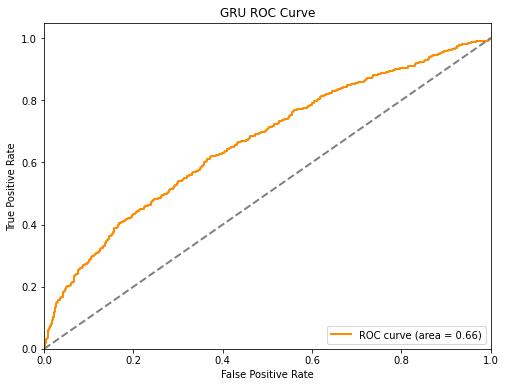

In [9]:
test_probabilities = model.predict(test_features)

# AUC score
auc_score = roc_auc_score(test_labels, test_probabilities)
print(f'Test AUC: {auc_score}')

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GRU ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
test_predictions = (test_probabilities >= 0.5).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Precision: 0.2693333333333333
Recall: 0.7026086956521739
F1-Score: 0.3893975903614457


In [11]:
results_df = pd.DataFrame({
    'ID': test_data['subject_id'].sort_values().unique(),
    'Probability': test_probabilities.flatten(),
    'Mortality': test_labels
})
results_df.to_csv('ts_gru.csv', index=False)